# 'Seeing' digits: an interpretability dive into MLPs trained on MNIST data

## Part 02. Extending notebook 2 with hooks, neuron health and visualization

## 0. The why?

My goal is to start digging into some tools used in interpretability. Looking at any paper on the subject we researchers probing the inner layers of models, asking questions like

> What 'features' does the model learn? Do neurons specialize?

Take the Anthropic paper *"Toy Models of Superposition"*, for example — it notes that some models, especially vision models, learn **interpretable features**: neurons that respond to horizontal lines, floppy ears, curves, and so on. These are patterns that we can understand, and when a neuron cleanly represents such a pattern, we call it interpretable. The goal-broadly-will be to interpret (understand) the black box of neural networks. But before that, the question that we hope to start working towards in this notebook is how do we begin to understand what neurons are specializing in? How do we ask what individual neurons look for in the data, and how do we study the specifics of the model as training evolves. We need to build an *interpretability toolbox* that will allow us to address these questions, and ultimately aid in our interpretation of other projects/repos that we have in the pipeline. 



---
**Interpretability tools** This notebook will just be scratching the surface but towards the goal of understanding neural networks we need to be able to 'probe' inner layers and neurons to 'see' how they respond during training and eventually to understand what they are looking for in the data. We begin by asking basic questions, like those raised in Karpathy’s Zero-to-Hero series:
- how does data normalization (or rather non-normalization) affect model behavior?
- What happens to hidden layer activations during training?
- Do neurons become inactive (“dead”) or oversaturated? (moving this to the next notebook)

From there, we'll get into tools like:
- Activation histograms and sparsity analysis
- Gradient tracking
- PCA or t-SNE on hidden representations
- Class-wise activation probing


---
**Notebook plan** (for now)
1) The first thing we do (in notebook 01) is attempt to understand the most naive (baseline) approach: take non-normalized MNIST data and run it through an MLP. What happens to the activations in the hidden layers? Specifically we study the statistics using histograms to aid in our understanding.
2) In notebook 02 we continue probing the model in both forward and backward passes (via hooks). Ask about possible neuron death due to raw data and drifting means/growing variance. 
3) In notebook 03 we will normalize the data and see how the model improves (if it does). Once we have a solid MLP where the activation statistics do not fluctuate too much through the training evolution we set our sights on more specific interpretability tools: gradient tracking, activation heatmaps/trajectories, PCA/t-SNE, etc.
4) We may then compare both normalized, and un-normalized setups to see/understand how tweaking the data (and the model) helps the model specialize.
5) In notebook 04 we will try the same with a CNN where we expect the spacial model to do much better but also (hopefully) be much more interpretable.


---
**Why MNIST**? There are many reasons to start here and they might not seem overly 'sexy' given the state of the art but I think it is a useful dataset to work on and is very natural starting place once we understand MLPs: 
1) MNIST is arguably one of the most basic training examples and one that we understand fairly well
2) MLPs perform fairly well on this dataset but with vectorized data there might be more space for vague interpretability
3) CNNs are the spacial models that seem to specialize a bit more and hence should be more clearly interpretable
4) We ended our [Micrograd experimentation](https://github.com/eriktholmes/Zero-to-hero-course/tree/main/episode-1/experiments/MNIST) with the MNIST data so why not pick up there!?

## 1. Overview/goals

This notebook is the **second** in a multi-part interpretability exploration. Here, we extend our study of MLP performance and interal exporation on non-normalized MNIST data. Our focus in this notebook is to investigate the following:

> - Neuron death rate
> - Gradient tracking
> - More detailed later layer analysis
> - Maybe explore some 'pixel activation maps'

To answer these questions, we utilize/implement the following tools:

> - Hooks
> - PCA
> - etc.

Let's get into it!

## 2. MNIST data

In [2]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

## 3. Constructing an MLP and training on MNIST 

### 3.1. The model

In [22]:
import torch
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(28*28, 32)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(32, 16)
        self.relu2 = nn.ReLU()
        self.output = nn.Linear(16, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x1 = self.linear1(x)
        x2 = self.relu1(x1)
        x3 = self.linear2(x2)
        x4 = self.relu2(x3)
        out = self.output(x4)
        return out

### 3.2. Talkin bout hooks

**Note**: In the previous notebook, we used a straightforward approach to track internal activations — namely, assigning them manually during each forward pass (for example, ```self.linear1_out = self.linear1(x)```). While this approach works for small experiments, it's quite naive and not great for scalablility! If we alter the model we need to update every forward call where we log these values. 

This manual approach is not ideal for the reasons we gave above and so this time we will introduce 'hooks', which are functions that allow us to observe the internal signals of a model without modifying the model’s forward method. Examples of the internal 'signals' are activations during the forward pass (like last time!) or gradients during the backward pass (for this time!). 

**Focus for this section**: gradient tracking via *backward hooks*. Our goal is to analyze how the model’s internal layers respond to different input classes. By registering a hook on a layer (e.g., ```linear1```), we can inspect the gradients flowing through its output neurons during backpropagation.

Since we studied activations during the forward pass last time we are going to focus on gradient tracking next: using hooks we hope to capture the gradient of each neuron which will give us some indication of how 'important' that neuron is to the training example. Ideally we will capture class based gradients to see if certain neurons receive consistently higher gradients for a given class — suggesting they play a more significant role in class based decision making. 

Specifically we would like to learn about questions like:
- Do certain neurons consistently receive larger gradients when processing images of a particular digit?
- Do "confusable" classes (e.g., 3 vs 8 from our last notebook) produce similar or distinct "gradient patterns"?
- Can we uncover class-specialized or redundant neurons?

#### 3.2.1. Activation hooks
This will replace what we did naively last time

In [103]:
class ActivationHook:
    def __init__(self, module):
        self.module = module
        self.activations = []
        self.hook_handle = None

    def _hook_fn(self, module, input, output):
        self.activations.append(output.detach())

    def register(self):
        self.hood_handle = self.module.register_forward_hook(self._hook_fn)

    def remove(self):
        if self.hook_handle is not None:
            self.hook_handle.remove()

    def clear(self):
        self.activations.clear()

#### 3.2.2. Gradient hooks
Same structure, this time for gradient tracking

In [69]:
class GradientHook:
    def __init__(self, module):
        self.module = module
        self.gradients = []
        self.hook_handle = None

    def _hook_fn(self, module, grad_input, grad_output):
        self.gradients.append(grad_output[0].detach())

    def register(self):
        self.hook_handle = self.module.register_full_backward_hook(self._hook_fn)

    def remove(self):
        if self.hook_handle is not None:
            self.hook_handle.remove()

    def clear(self):
        self.gradients.clear()

### 3.3 initialize the model with activation hooks and train

In [176]:
model = MLP()
layer1_hook = ActivationHook(model.linear1)
layer1_hook.register()

from collections import defaultdict
layer1_activations = defaultdict(list)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

epochs = 20

for epoch in range(epochs):
    running_loss = 0.0
    running_correct = 0
    total = 0
    
    for xs, ys in train_loader:
        layer1_hook.clear()

        yout = model(xs)
        loss = loss_fn(yout, ys)

        acts = layer1_hook.activations[0]  # shape: [batch_size, neurons]
        layer1_activations[epoch].append(acts.detach().cpu())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        predictions = torch.argmax(yout, dim=1)
        running_correct += (predictions == ys).sum().item()
        running_loss += loss.item() * xs.size(0)
        total += xs.size(0)
        
    if epoch % 5 == 0:
        print(f"Epoch {epoch} — Loss: {running_loss / total:.4f}, Accuracy: {(running_correct / total)*100:.4f}%")   
     

Epoch 0 — Loss: 1.8995, Accuracy: 39.7083%
Epoch 5 — Loss: 0.3281, Accuracy: 90.7583%
Epoch 10 — Loss: 0.2439, Accuracy: 93.1233%
Epoch 15 — Loss: 0.2022, Accuracy: 94.2850%


### 3.3.1. Sanity check (plotting mean/std across epochs)

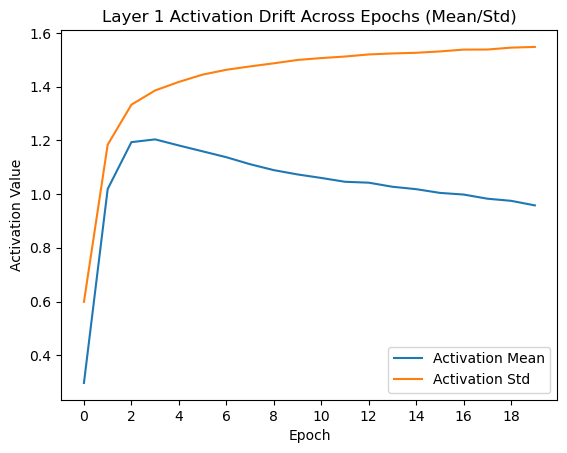

In [180]:
import matplotlib.pyplot as plt

epoch_means = []
epoch_stds = []

for epoch in range(epochs):
    epoch_tensor = torch.cat(layer1_activations[epoch], dim=0)  # shape: [N, neurons]
    epoch_means.append(epoch_tensor.mean().item())
    epoch_stds.append(epoch_tensor.std().item())

plt.plot(epoch_means, label="Activation Mean")
plt.plot(epoch_stds, label="Activation Std")
plt.title("Layer 1 Activation Drift Across Epochs (Mean/Std)")
plt.xticks([i for i in range(epochs) if i % 2 == 0])
plt.xlabel("Epoch")
plt.ylabel("Activation Value")
plt.legend()
plt.show()

### 3.3.2. Model performance

In [195]:
total = 0
correct = 0

for x, y in test_dataset:
    out = model(x.view(-1, 28*28))
    pred = torch.argmax(out, dim=1)
    if pred == y:
        correct += 1
    total += 1

print(f'Model accuracy: {correct/total*100:.2f}%')

Model accuracy: 94.80%


### 3.3.3. Hooking gradients

In [376]:
model.eval()
lay2_grad_hook = GradientHook(model.linear2)
lay2_grad_hook.register()
lay2_act_hook = ActivationHook(model.linear2)
lay2_act_hook.register()

gradients_by_class = defaultdict(list)
acts_by_class = defaultdict(list)

for x, y in train_dataset:
    model.zero_grad()
    lay2_grad_hook.clear()
    lay2_act_hook.clear()
    y = torch.tensor([y])

    out = model(x)
    loss = loss_fn(out, y)
    loss.backward()

    act = lay2_act_hook.activations[0].squeeze(0).detach()
    acts_by_class[y.item()].append(act)
    grad = lay2_grad_hook.gradients[0].squeeze(0).detach()
    gradients_by_class[y.item()].append(grad)

In [327]:
zero_grad_class = torch.stack(gradients_by_class[0])

In [329]:
zero_grad_class.size(1)

16

In [378]:
mean_grads_by_class = defaultdict(list)
mean_acts_by_class = defaultdict(list)

for i in range(10):
    grads = torch.stack(gradients_by_class[i])
    acts = torch.stack(gradients_by_class[i])
    mean_grads_by_class[i].append(grads.mean(dim=0))
    mean_acts_by_class[i].append(acts.mean(dim=0))

In [382]:
for i in range(10):
    top_neurons_grad = torch.topk(mean_grads_by_class[i][0], k=5).indices
    top_neurons_act = torch.topk(mean_acts_by_class[i][0], k=5).indices
    print(f"GRADS: Top neurons for class {i}: {top_neurons_grad.tolist()}")
    print(f"ACTS: Top neurons for class {i}: {top_neurons_act.tolist()}")
    print()

GRADS: Top neurons for class 0: [0, 12, 7, 1, 13]
ACTS: Top neurons for class 0: [0, 12, 7, 1, 13]

GRADS: Top neurons for class 1: [5, 6, 14, 1, 3]
ACTS: Top neurons for class 1: [5, 6, 14, 1, 3]

GRADS: Top neurons for class 2: [6, 15, 1, 7, 12]
ACTS: Top neurons for class 2: [6, 15, 1, 7, 12]

GRADS: Top neurons for class 3: [14, 13, 12, 7, 2]
ACTS: Top neurons for class 3: [14, 13, 12, 7, 2]

GRADS: Top neurons for class 4: [5, 2, 3, 0, 15]
ACTS: Top neurons for class 4: [5, 2, 3, 0, 15]

GRADS: Top neurons for class 5: [2, 15, 6, 11, 14]
ACTS: Top neurons for class 5: [2, 15, 6, 11, 14]

GRADS: Top neurons for class 6: [12, 3, 1, 0, 10]
ACTS: Top neurons for class 6: [12, 3, 1, 0, 10]

GRADS: Top neurons for class 7: [5, 6, 7, 14, 2]
ACTS: Top neurons for class 7: [5, 6, 7, 14, 2]

GRADS: Top neurons for class 8: [13, 3, 11, 0, 15]
ACTS: Top neurons for class 8: [13, 3, 11, 0, 15]

GRADS: Top neurons for class 9: [11, 0, 14, 1, 3]
ACTS: Top neurons for class 9: [11, 0, 14, 1, 3]



Based on the above, we conjecture that the fifth neuron layer 2 has the highest gradient mean for all classes with a vertical line. 

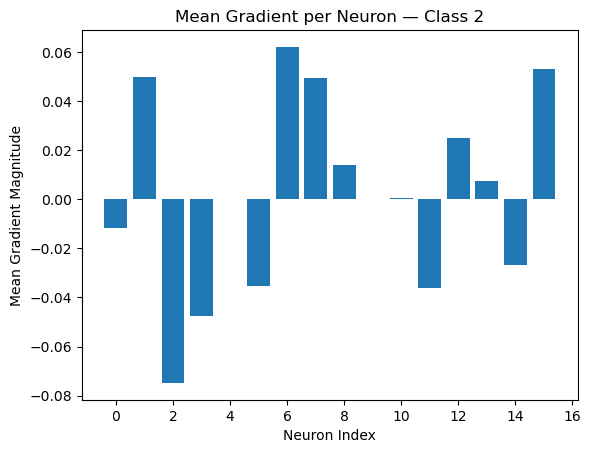

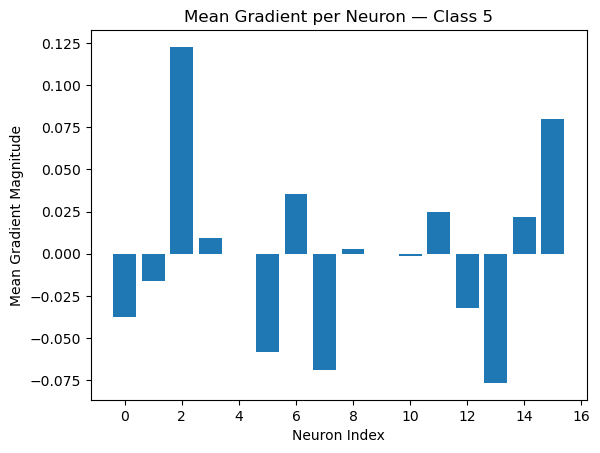

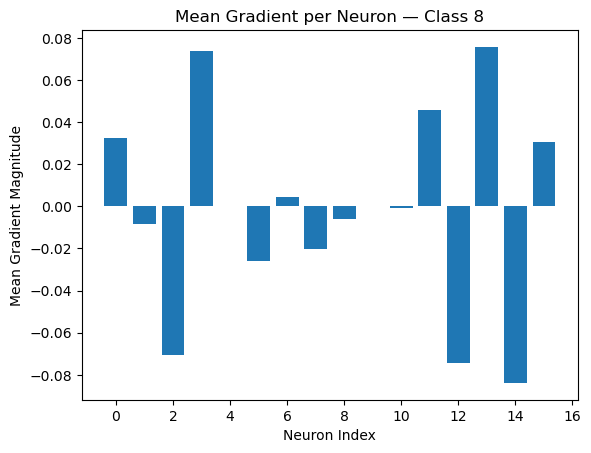

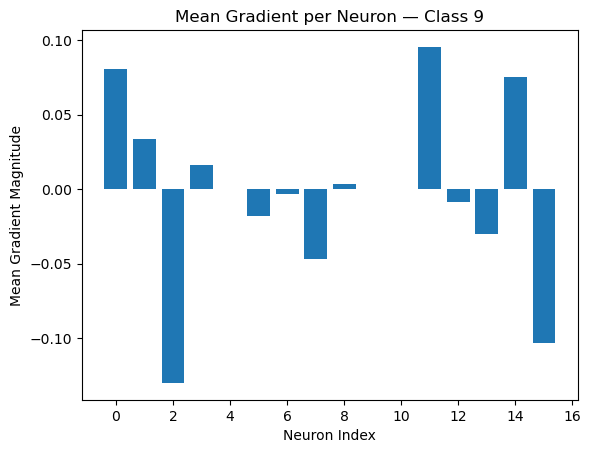

In [369]:
for cls in [2, 5, 8, 9]:
    plt.bar(range(len(mean_grads_by_class[cls][0])), mean_grads_by_class[cls][0])
    plt.title(f"Mean Gradient per Neuron — Class {cls}")
    plt.xlabel("Neuron Index")
    plt.ylabel("Mean Gradient Magnitude")
    plt.show()

In [365]:
class_based_total = {i:0 for i in range(10)}
class_based_correct = {i:0 for i in range(10)}

for x,y in test_dataset:
    out = model(x)
    pred = torch.argmax(out, dim=1)
    if pred.item() == y:
        class_based_correct[y] += 1
    class_based_total[y] += 1

In [367]:
for i in range(10):
    print(f'Model accuracy on class {i}: {class_based_correct[i]/class_based_total[i]*100:.2f}%')

Model accuracy on class 0: 98.27%
Model accuracy on class 1: 97.80%
Model accuracy on class 2: 93.51%
Model accuracy on class 3: 94.55%
Model accuracy on class 4: 96.33%
Model accuracy on class 5: 92.83%
Model accuracy on class 6: 95.72%
Model accuracy on class 7: 94.55%
Model accuracy on class 8: 93.84%
Model accuracy on class 9: 90.19%


In [434]:
i = 5
corr, _ = spearmanr(acts[:, i], grads[:, i])
print(corr)

0.4727448917882596
